### Imports

In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = '../data/augmented/'

### Read augmented images from folder

In [2]:
files = os.listdir(DATASET_PATH)

rawx=[]
rawy=[]
for file in files:
    img = cv2.imread(os.path.join(DATASET_PATH,file),cv2.IMREAD_GRAYSCALE)
    rawx.append(img)
    rawy.append(int(file.split('_')[1]))

In [3]:
im_h, im_w = rawx[0].shape
num_classes = len(np.unique(rawy))

In [4]:
x = np.asarray(rawx)
y = np.asarray(rawy)
x = x.reshape(len(files),im_h,im_w,1)
print(x.shape)
print(y.shape)

(12000, 100, 100, 1)
(12000,)


In [5]:
rawx= None
rawy= None

In [6]:
x = x / 255.

In [7]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([2000, 2000, 2000, 2000, 2000, 2000], dtype=int64))

### Create train/test set

In [8]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,stratify=y)

In [9]:
x = None
y = None

### Check how the images looks like

In [10]:
def plot_6_images(xt,yt):
    
    idxs = [ random.randint(0,len(xt)) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        plt.title('y={}'.format(yt[idxs[i]]))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

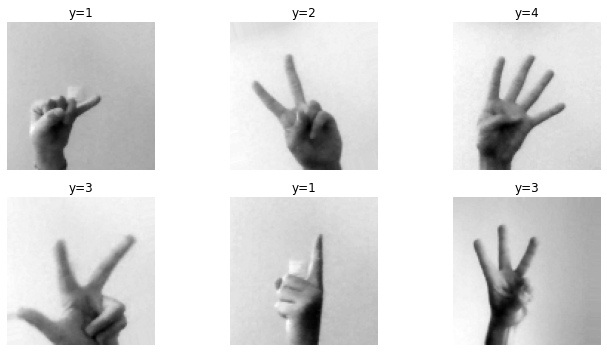

In [11]:
plot_6_images(xtrain,ytrain)

### Create Keras FC Model

In [34]:
from keras.backend import clear_session

clear_session()
model = None

In [35]:
from keras.utils import to_categorical

ytrain_cat = to_categorical(ytrain, num_classes)
ytest_cat = to_categorical(ytest, num_classes)

In [36]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam, Adadelta
from keras.metrics import categorical_accuracy

model = Sequential()

model.add(Flatten(input_shape=(im_w,im_h,1)))
model.add(Dense(2048, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.125))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(6, activation="softmax"))

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=[categorical_accuracy])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              20482048  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

### Train FC NN

In [37]:
from keras.callbacks import EarlyStopping
EPOC = 25
# BS = 64
# batch_size=BS,

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
history = model.fit(xtrain, ytrain_cat, validation_split=0.2,  epochs=EPOC, callbacks=[es])


Train on 7680 samples, validate on 1920 samples
Epoch 1/25
7680/7680 [==============================] - 24s 3ms/step - loss: 1.9762 - categorical_accuracy: 0.1678 - val_loss: 1.7921 - val_categorical_accuracy: 0.1484
Epoch 2/25
7680/7680 [==============================] - 23s 3ms/step - loss: 1.7983 - categorical_accuracy: 0.1664 - val_loss: 1.7925 - val_categorical_accuracy: 0.1484
Epoch 3/25
7680/7680 [==============================] - 25s 3ms/step - loss: 1.7949 - categorical_accuracy: 0.1699 - val_loss: 1.7926 - val_categorical_accuracy: 0.1484 1s - loss: 1.7951 
Epoch 4/25
7680/7680 [==============================] - 25s 3ms/step - loss: 1.7918 - categorical_accuracy: 0.1714 - val_loss: 1.7927 - val_categorical_accuracy: 0.1484
Epoch 5/25
7680/7680 [==============================] - 29s 4ms/step - loss: 1.7920 - categorical_accuracy: 0.1688 - val_loss: 1.7927 - val_categorical_accuracy: 0.1484
Epoch 6/25
7680/7680 [==============================] - 27s 4ms/step - loss: 1.7919 - ca

In [38]:
history.params

{'batch_size': 32,
 'epochs': 25,
 'steps': None,
 'samples': 7680,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'categorical_accuracy',
  'val_loss',
  'val_categorical_accuracy']}

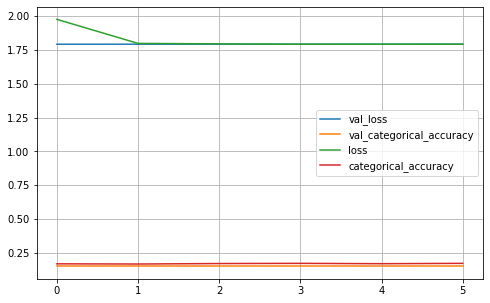

In [39]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()